In [444]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cnd_rent= pd.read_csv(R"C:\Users\kevca\Downloads\canada_rent.csv")

Here I am looking at any missing data. Sq_feet is missing a lot of data, including smoking. The next step will be to discard the data I do not believe is necessary. Though the sq_feet is 

In [447]:
cnd_rent.isnull().sum()

rentfaster_id           0
city                    0
province                0
address               125
latitude                0
longitude               0
lease_term             46
type                    0
price                   0
beds                  132
baths                 134
sq_feet              4112
link                    0
furnishing              0
availability_date      12
smoking              2702
cats                  173
dogs                  173
dtype: int64

I removed the data that was not necessary or if there was too much data missing.

In [449]:
from sklearn.impute import SimpleImputer

numerical_cols = cnd_rent.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = cnd_rent.select_dtypes(include=['object', 'category']).columns

numerical_imputer = SimpleImputer(strategy='median')
cnd_rent[numerical_cols] = numerical_imputer.fit_transform(cnd_rent[numerical_cols])

categorical_imputer = SimpleImputer(strategy='most_frequent')
cnd_rent[categorical_cols] = categorical_imputer.fit_transform(cnd_rent[categorical_cols])

cnd_rent = cnd_rent.drop(['rentfaster_id', 'address', 'latitude', 'longitude', 'lease_term', 'sq_feet', 'link', 'availability_date', 'smoking'], axis=1)

cnd_rent.isnull().sum()

city          0
province      0
type          0
price         0
beds          0
baths         0
furnishing    0
cats          0
dogs          0
dtype: int64

In [451]:
cnd_rent.head(10)

,city,province,type,price,beds,baths,furnishing,cats,dogs
0,Airdrie,Alberta,Townhouse,2495.0,2 Beds,2.5,Unfurnished,True,True
1,Airdrie,Alberta,Townhouse,2695.0,3 Beds,2.5,Unfurnished,True,True
2,Airdrie,Alberta,Townhouse,2295.0,2 Beds,2.5,Unfurnished,True,True
3,Airdrie,Alberta,Townhouse,2095.0,2 Beds,2.5,Unfurnished,True,True
4,Airdrie,Alberta,Townhouse,2495.0,2 Beds,2.5,Unfurnished,True,True
5,Airdrie,Alberta,Townhouse,2095.0,2 Beds,2.5,Unfurnished,True,True
6,Airdrie,Alberta,Townhouse,2495.0,2 Beds,2.5,Unfurnished,True,True
7,Airdrie,Alberta,Apartment,2390.0,Studio,1,Unfurnished,True,True
8,Airdrie,Alberta,Apartment,3615.0,1 Bed,1,Unfurnished,True,True
9,Airdrie,Alberta,Apartment,4520.0,2 Beds,1,Unfurnished,True,True


I wanted to see if there was any missing data in the price. I filled the missing data by adding a threshold so it can represent a realistic price amount.

In [454]:
price= cnd_rent.groupby('province')['price'].agg(['min', 'max']).reset_index()

print(price)

                    province     min      max
0                    Alberta     0.0  29990.0
1           British Columbia     0.0   9995.0
2                   Manitoba     0.0  18955.0
3              New Brunswick     0.0   2230.0
4  Newfoundland and Labrador   850.0   1365.0
5      Northwest Territories  1350.0   2775.0
6                Nova Scotia     0.0   7500.0
7                    Ontario     0.0  19170.0
8                     Quebec     0.0   8500.0
9               Saskatchewan   640.0   4500.0


In [456]:
cnd_rent['price'] = cnd_rent['price'].replace(0, pd.NA)

cnd_rent['price'] = cnd_rent.groupby('province')['price'].transform(lambda x: x.fillna(x.median()))

price = cnd_rent.groupby('province')['price'].agg(['min', 'max']).reset_index()

print(price)

                    province     min      max
0                    Alberta     1.0  29990.0
1           British Columbia   250.0   9995.0
2                   Manitoba   477.0  18955.0
3              New Brunswick   609.0   2230.0
4  Newfoundland and Labrador   850.0   1365.0
5      Northwest Territories  1350.0   2775.0
6                Nova Scotia   569.0   7500.0
7                    Ontario   425.0  19170.0
8                     Quebec     1.0   8500.0
9               Saskatchewan   640.0   4500.0


In [458]:
threshold_min = 400
cnd_rent_filtered = cnd_rent[cnd_rent['price'] >= threshold_min]
price_adjusted = cnd_rent_filtered.groupby('province')['price'].agg(['min', 'max']).reset_index()

print(price_adjusted)

                    province     min      max
0                    Alberta   400.0  29990.0
1           British Columbia   575.0   9995.0
2                   Manitoba   477.0  18955.0
3              New Brunswick   609.0   2230.0
4  Newfoundland and Labrador   850.0   1365.0
5      Northwest Territories  1350.0   2775.0
6                Nova Scotia   569.0   7500.0
7                    Ontario   425.0  19170.0
8                     Quebec   500.0   8500.0
9               Saskatchewan   640.0   4500.0


Here I see that there is some erroneous data. I filled the data with an estimated minimum price for the rent type.

In [461]:
rent_type = cnd_rent.groupby('type')['price'].agg(['min', 'max']).reset_index()
rent_type_filtered = rent_type[~rent_type['type'].isin(['Office Space', 'Parking Spot', 'Storage'])]

rent_type_filtered

,type,min,max
0,Acreage,1950.0,5995.0
1,Apartment,1.0,19170.0
2,Basement,595.0,3900.0
3,Condo Unit,895.0,9500.0
4,Duplex,650.0,7500.0
5,House,1.0,29990.0
6,Loft,1150.0,2600.0
7,Main Floor,650.0,4000.0
8,Mobile,1500.0,2900.0
11,Room For Rent,500.0,3100.0


In [497]:
threshold_type = 400

filtered_type = cnd_rent[cnd_rent['price'] >= threshold_type]
new_rent_type = filtered_type.groupby('type')['price'].agg(['min', 'max', 'mean']).reset_index()
new_rent_type['mean'] = new_rent_type['mean'].round(2)
new_rent_type = new_rent_type[~new_rent_type['type'].isin(['Office Space', 'Parking Spot', 'Storage'])]

new_rent_type

,type,min,max,mean
0,Acreage,1950.0,5995.0,3881.36
1,Apartment,477.0,19170.0,2157.80
2,Basement,595.0,3900.0,1559.21
3,Condo Unit,895.0,9500.0,2263.81
4,Duplex,650.0,7500.0,2406.08
5,House,550.0,29990.0,3187.33
6,Loft,1150.0,2600.0,1861.16
7,Main Floor,650.0,4000.0,2207.39
8,Mobile,1500.0,2900.0,2200.00
11,Room For Rent,500.0,3100.0,919.59


The graph below represents the price and type of unit for every province.

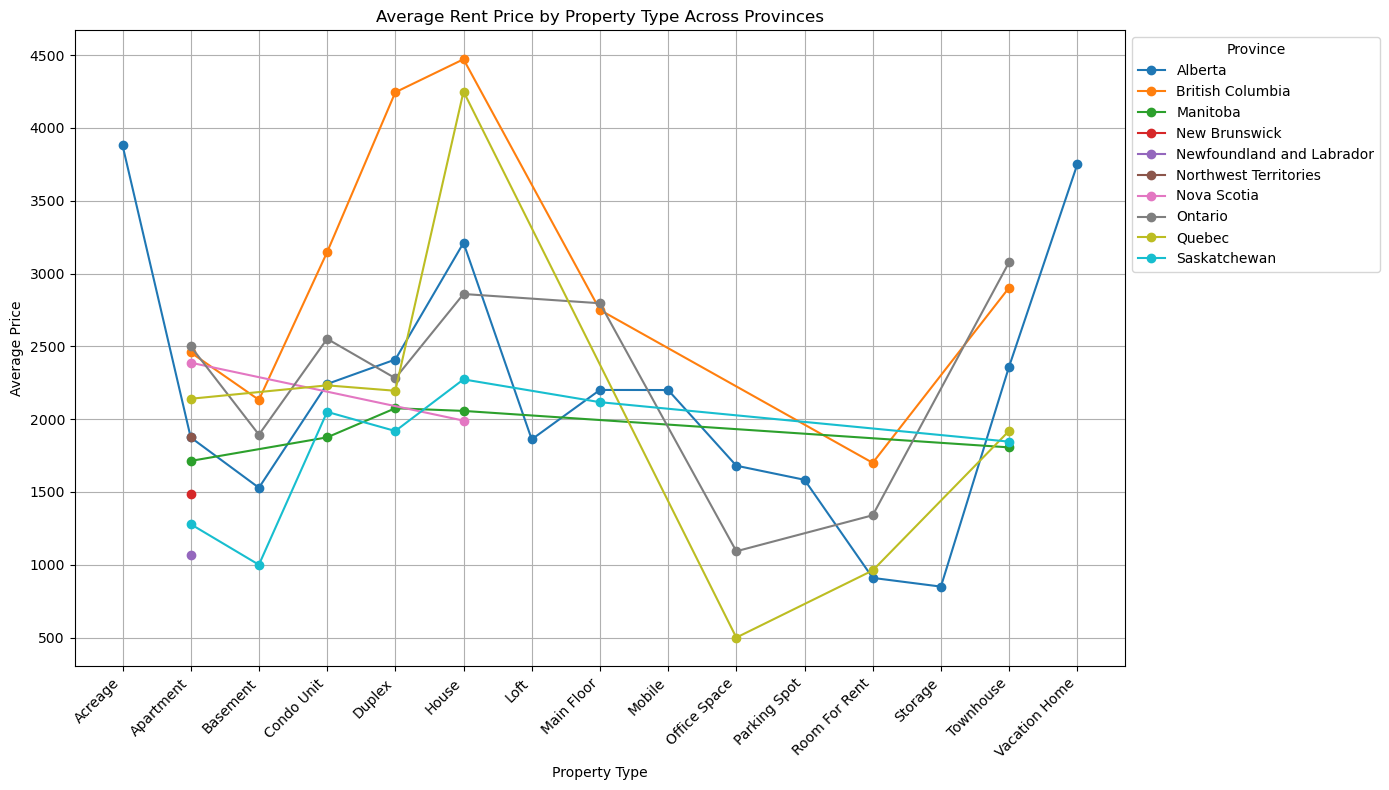

In [354]:
average_rent_type_province = filtered_type.groupby(['province', 'type'])['price'].mean().reset_index()

plt.figure(figsize=(14, 8))

for province in average_rent_type_province['province'].unique():
    province_data = average_rent_type_province[average_rent_type_province['province'] == province]
    plt.plot(province_data['type'], province_data['price'], marker='o', label=province)

plt.title('Average Rent Price by Property Type Across Provinces')
plt.xlabel('Property Type')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.legend(title='Province', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()

The graph below represents the property type and their average min and max price.

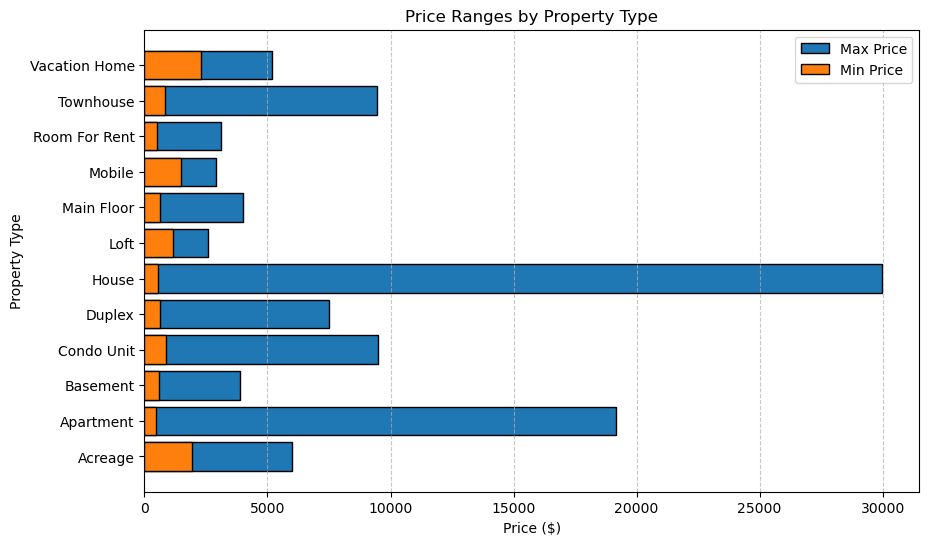

In [350]:
plt.figure(figsize=(10, 6))
plt.barh(new_rent_type['type'], new_rent_type['max'], edgecolor='black', label='Max Price')
plt.barh(new_rent_type['type'], new_rent_type['min'], edgecolor='black', label='Min Price')

plt.xlabel('Price ($)')
plt.ylabel('Property Type')
plt.title('Price Ranges by Property Type')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

This graph represents the number of beds and the average price in each province.

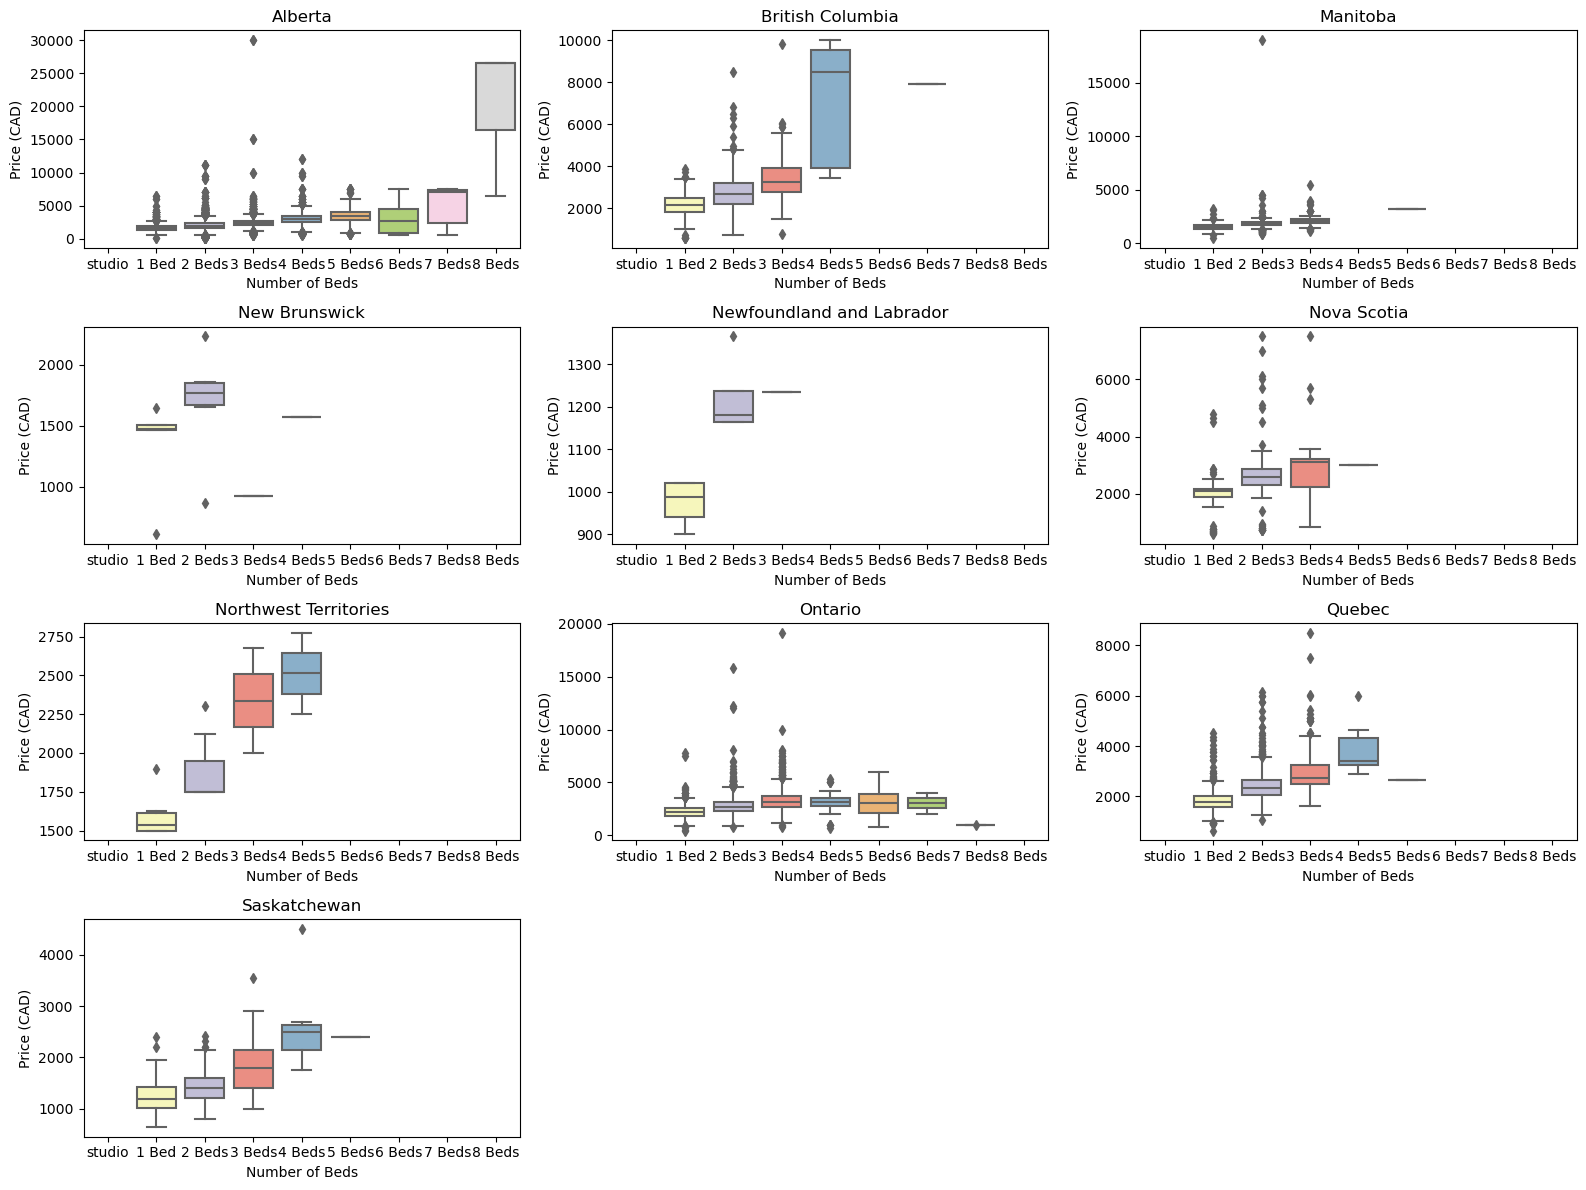

In [255]:
provinces = cnd_rent['province'].unique()

plt.figure(figsize=(16, 12))

bed_order = ['studio','1 Bed', '2 Beds', '3 Beds', '4 Beds', '5 Beds', '6 Beds', '7 Beds', '8 Beds']
for i, province in enumerate(provinces):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x='beds', y='price', data=cnd_rent[cnd_rent['province'] == province], 
                palette='Set3', order=bed_order)
    plt.title(f'{province}')
    plt.xlabel('Number of Beds')
    plt.ylabel('Price (CAD)')

plt.tight_layout()
plt.show()

The following, I used the linear regression model, random forest model, and gradient boosting model to determine which of them can predict the price better. I compared each model and cross-validated it to determine their performance to help choose which is best at predicting prices. 

In [503]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = pd.get_dummies(cnd_rent.drop('price', axis=1), drop_first=True)
y = cnd_rent['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
y_pred_linear = linear_regression.predict(X_test)
linear_mae = mean_absolute_error(y_test, y_pred_linear)
linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)

random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

gradient_boosting = GradientBoostingRegressor(random_state=42)
gradient_boosting.fit(X_train, y_train)
y_pred_gb = gradient_boosting.predict(X_test)
gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_mse = mean_squared_error(y_test, y_pred_gb)
gb_r2 = r2_score(y_test, y_pred_gb)

results = {
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "MAE": [linear_mae, rf_mae, gb_mae],
    "MSE": [linear_mse, rf_mse, gb_mse],
    "R-squared": [linear_r2, rf_r2, gb_r2]
}

results_df = pd.DataFrame(results)

print(results_df)


               Model           MAE           MSE     R-squared
0  Linear Regression  3.036303e+12  7.339737e+27 -8.262587e+21
1      Random Forest  2.899473e+02  3.275205e+05  6.312993e-01
2  Gradient Boosting  3.493135e+02  4.548029e+05  4.880132e-01


In [508]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=50),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42, n_estimators=50)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    results[model_name] = -cv_scores.mean()

for model_name, score in results.items():
    print(f'{model_name}: Mean MAE = {score:.2f}')

Linear Regression: Mean MAE = 1585644091444.41
Random Forest: Mean MAE = 283.52
Gradient Boosting: Mean MAE = 368.58


The best performing model is the Random Forest model for predicting rental prices. It has a lower MAE, MSE and highest r-square value which indicates that it will provide the most accurate predictions. the Random Forest model also has a much lower MAE which means it is better than the other models at capturing underlying patterns in the data.

In [540]:
future_price = {
    'province_Quebec': [0],
    'bedrooms_3': [3],
    'baths': [0],
    'type_Apartment': [0],
}

future_input_df = pd.DataFrame(future_price)

for col in X_train.columns:
    if col not in future_input_df.columns:
        future_input_df[col] = 0

future_input_df = future_input_df[X_train.columns]

predicted_prices = random_forest.predict(future_input_df)
predicted_prices_rounded = predicted_prices.round(2)

print(f"Predicted Future Rental Prices: {predicted_prices_rounded}")

Predicted Future Rental Prices: [2323.59]


C:\Users\kevca\AppData\Local\Temp\ipykernel_64780\4112010161.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_input_df[col] = 0
C:\Users\kevca\AppData\Local\Temp\ipykernel_64780\4112010161.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future_input_df[col] = 0
C:\Users\kevca\AppData\Local\Temp\ipykernel_64780\4112010161.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin